In [1]:
# libraries
import numpy as np
# tensorflow packages
#!pip install tensorflow
import tensorflow as tf
#!pip install tensorflow-hub
#!pip install tensorflow-datasets
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [2]:
train_data, validation_data, test_data = tfds.load(name = "imdb_reviews",
                                                  split=('train[:60%]', 'train[60%:]', 'test'),
                                                  as_supervised=True)

In [3]:
train_data
print("GPU IS", "AVAILABLE" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU IS NOT AVAILABLE


In [4]:
train_example_batch, train_label_batch = next(iter(train_data.batch(10)))

In [5]:
train_example_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [6]:
train_label_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64)>

In [7]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [8]:
hub_layer(train_example_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 400373 (1.53 MB)
Trainable params: 400373 (1.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [12]:
history = model.fit(train_data.shuffle(10000).batch(100), epochs = 25,
                   validation_data = validation_data.batch(100), verbose=1)

Epoch 1/25
150/150 [==============================] - 8s 33ms/step - loss: 0.6019 - accuracy: 0.6467 - val_loss: 0.5283 - val_accuracy: 0.7225
Epoch 2/25
150/150 [==============================] - 5s 31ms/step - loss: 0.4573 - accuracy: 0.7733 - val_loss: 0.4202 - val_accuracy: 0.8112
Epoch 3/25
150/150 [==============================] - 4s 27ms/step - loss: 0.3596 - accuracy: 0.8369 - val_loss: 0.3627 - val_accuracy: 0.8326
Epoch 4/25
150/150 [==============================] - 4s 27ms/step - loss: 0.2974 - accuracy: 0.8713 - val_loss: 0.3311 - val_accuracy: 0.8545
Epoch 5/25
150/150 [==============================] - 4s 27ms/step - loss: 0.2532 - accuracy: 0.8943 - val_loss: 0.3131 - val_accuracy: 0.8631
Epoch 6/25
150/150 [==============================] - 5s 34ms/step - loss: 0.2182 - accuracy: 0.9127 - val_loss: 0.3075 - val_accuracy: 0.8589
Epoch 7/25
150/150 [==============================] - 5s 31ms/step - loss: 0.1897 - accuracy: 0.9269 - val_loss: 0.3004 - val_accuracy: 0.8721

In [15]:
results = model.evaluate(test_data.batch(100),verbose=2)

for name, values in zip(model.metrics_names, results):
    print("%s: %.3f" %(name, values))

250/250 - 3s - loss: 0.6653 - accuracy: 0.8386 - 3s/epoch - 14ms/step
loss: 0.665
accuracy: 0.839


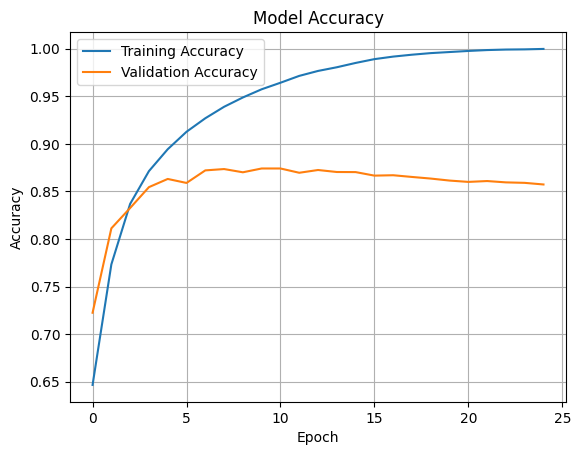

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

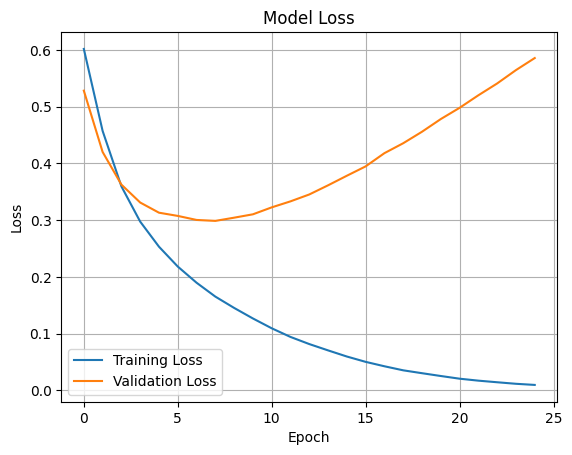

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
import pandas as pd

df = pd.DataFrame(history.history)
df.to_csv("training_metrics.csv", index=False)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_data.shuffle(10000).batch(100),
                    epochs=25,
                    validation_data=validation_data.batch(100),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/25
150/150 [==============================] - 7s 48ms/step - loss: 0.0079 - accuracy: 0.9997 - val_loss: 0.6039 - val_accuracy: 0.8570
Epoch 2/25
150/150 [==============================] - 6s 41ms/step - loss: 0.0066 - accuracy: 0.9998 - val_loss: 0.6250 - val_accuracy: 0.8569
Epoch 3/25
150/150 [==============================] - 6s 41ms/step - loss: 0.0056 - accuracy: 0.9999 - val_loss: 0.6456 - val_accuracy: 0.8565
Epoch 4/25
150/150 [==============================] - 6s 40ms/step - loss: 0.0048 - accuracy: 0.9999 - val_loss: 0.6646 - val_accuracy: 0.8564


In [24]:
model.save("sentiment_model.keras")